In [60]:
import collections
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, shgo, LinearConstraint, root
from scipy.signal import find_peaks
import math

In [61]:
#True probability
supp = np.asarray([1, 1.5, 2, 2.5, 3, 3.5])
weight = np.asarray([0.1, 0.3, 0.1, 0.1, 0.1, 0.3])

#Sample
n = 50000
sample = np.random.choice(supp, n, p = weight)
poisson_sample = np.random.poisson(sample)
counter = collections.Counter(poisson_sample)
poisson_obs = np.asarray([i for i in counter.keys()])
poisson_weight = np.asarray([i/n for i in counter.values()]) 
q = len(poisson_obs)

#Estimator
G_supp = np.asarray([np.random.uniform(0, 4)])
G_weight = np.asarray([1])

In [62]:
def phi(supp, weight, poisson_obs, poisson_weight):
    s = 0
    for i in range (np.shape(poisson_obs)[0]):
        d = 0
        for j in range (np.shape(supp)[0]):
            d += weight[j] * np.exp(- supp[j]) * (supp[j] ** poisson_obs[i]) / math.factorial(poisson_obs[i])
        s += poisson_weight[i] * np.log(poisson_weight[i] / d)
    return s


def phi_derivative(x, supp, weight, poisson_obs, poisson_weight):
    s = 0
    for i in range (np.shape(poisson_obs)[0]):
        d = 0
        for j in range (np.shape(supp)[0]):                
            d += weight[j] * np.exp(-supp[j]) * (supp[j] ** poisson_obs[i])
        s += poisson_weight[i] * (x ** poisson_obs[i]) / d    
    return 1- np.exp(-x) * s

def vdm_epsilon(eps, supp, weight, min_lambda, poisson_obs, poisson_weight):
    weight = weight * (1 - eps)
    weight = np.append(weight, eps)
    supp = np.append(supp, min_lambda)
    return phi(supp, weight, poisson_obs, poisson_weight)

def isdm_epsilon(w, supp, weight, peaks_supp, poisson_obs, poisson_weight):
    weight = np.append(weight * w[0], w[1:])
    supp = np.append(supp, peaks_supp)
    return phi(supp, weight, poisson_obs, poisson_weight)

def emp_epsilon(theta, supp, weight, poisson_obs, poisson_weight):
    s = 0
    for i in range(np.shape(poisson_obs)[0]):
        d = 0
        for j in range(np.shape(supp)[0]):
            d += weight[j] * np.exp(-supp[j]) * (supp[j] ** poisson_obs[i]) 
        coef = - poisson_weight[i] / d
        if poisson_obs[i] == 0:
            s += -coef
        elif poisson_obs[i] == 1:
            s += coef * (1 - theta)
        else:
            s += coef * (poisson_obs[i] * (theta ** (poisson_obs[i] - 1)) - (theta ** poisson_obs[i]))
    return s

In [63]:
#VDM

G_weight_VDM = G_weight
G_supp_VDM = G_supp
result_vdm = np.zeros((2, 40))

for k in range (40):
    min_lambda = shgo(phi_derivative, args = (G_supp_VDM, G_weight_VDM, poisson_obs, poisson_weight), bounds = [(0, 4)]).x
    min_epsilon = shgo(vdm_epsilon, args = (G_supp_VDM, G_weight_VDM, min_lambda, poisson_obs, poisson_weight), bounds = [(0, 1)]).x
    
    G_weight_VDM = G_weight_VDM * (1 - min_epsilon)
    G_weight_VDM = np.append(G_weight_VDM, min_epsilon)
    G_supp_VDM = np.append(G_supp_VDM, min_lambda)
    
    result_vdm[0, k] = phi(G_supp_VDM, G_weight_VDM, poisson_obs, poisson_weight)
    result_vdm[1, k] = np.shape(G_supp_VDM)[0]

C:\Users\kwlim\AppData\Local\Temp\ipykernel_77168\3756375741.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  s += poisson_weight[i] * np.log(poisson_weight[i] / d)


In [64]:
#ISDM

G_weight_ISDM = G_weight
G_supp_ISDM = G_supp
result_isdm = np.zeros((2, 40))

for l in range (40):
    
    data = np.zeros(10000)
    for i in range(10000):
        data[i] = phi_derivative(i * 4 / 10000, G_supp_ISDM, G_weight_ISDM, poisson_obs, poisson_weight)
    peaks, _ = find_peaks(-data)
    if np.shape(peaks)[0] == 0:
        if data[0] <= data[-1]:
            peaks = np.append(peaks, [0])
        else:
            peaks = np.append(peaks, [10000 - 1])
    peaks_supp = np.asarray(peaks) * 4 / 10000

    k = np.shape(peaks_supp)[0]
    w0 = np.ones(k + 1) / (k + 1)
    w = minimize(isdm_epsilon, w0, args = (G_supp_ISDM, G_weight_ISDM, peaks_supp, poisson_obs, poisson_weight), bounds = [(0, 1)] * (k + 1), constraints = [LinearConstraint(np.ones((1, k + 1)), np.array([1]), np.array([1]))]).x

    G_weight_ISDM = np.append(G_weight_ISDM * w[0], w[1:])
    G_supp_ISDM = np.append(G_supp_ISDM, peaks_supp)

    result_isdm[0, l] = phi(G_supp_ISDM, G_weight_ISDM, poisson_obs, poisson_weight)
    result_isdm[1, l] = np.shape(G_supp_ISDM)[0]

In [65]:
#JPW

def phi_1(weight, supp, poisson_obs, poisson_weight):
    return phi(supp, weight, poisson_obs, poisson_weight)

eta_1 = 0.05
eta_2 = 0.001

G_weight_EMP = np.ones(4 * 100) / (4 * 100)
G_supp_EMP = np.arange(1, 4 * 100 + 1) / 100
result_emp = np.zeros((2, 40))

for k in range (40):
    
    sol = root(emp_epsilon, x0 = 2, args = (G_supp_EMP, G_weight_EMP, poisson_obs, poisson_weight)).x
    sol_1 = []
    for i in sol:
        if 0 <= i and i <= 4:
            sol_1.append(i)

    A = []
    for i in range (np.shape(G_supp_EMP)[0]):
        A.append((G_supp_EMP[i], G_weight_EMP[i]))
    for i in range(len(sol_1)):
        A.append((sol_1[i], 0))
    A.sort()
    G_supp_EMP = np.asarray([i[0] for i in A])
    G_weight_EMP = np.asarray([i[1] for i in A])

    supp = [G_supp_EMP[0]]
    s = [0]
    for i in range (np.shape(G_supp_EMP)[0]):                
        if supp[-1] + eta_1 < G_supp_EMP[i]:
            supp.append(G_supp_EMP[i])
            s.append(G_weight_EMP[i])
        else:
            s[-1] += G_weight_EMP[i]
    w0 = np.asarray(s)

    d = np.shape(w0)[0]
    w = minimize(phi_1, w0, args = (supp, poisson_obs, poisson_weight), bounds = [(0, 1)] * d, constraints = [LinearConstraint(np.ones((1, d)), np.array([1]), np.array([1]))]).x
    
    G_weight_EMP = []
    G_supp_EMP = []
    
    for i in range (np.shape(w)[0]):
        if w[i] > eta_2:
            G_weight_EMP.append(w[i])
            G_supp_EMP.append(supp[i])
    
    G_weight_EMP = np.asarray(G_weight_EMP)
    G_weight_EMP = G_weight_EMP / np.linalg.norm(G_weight_EMP, ord = 1)
    G_supp_EMP = np.asarray(G_supp_EMP)

    result_emp[0, k] = phi(G_supp_EMP, G_weight_EMP, poisson_obs, poisson_weight)
    result_emp[1, k] = np.shape(G_supp_EMP)[0]


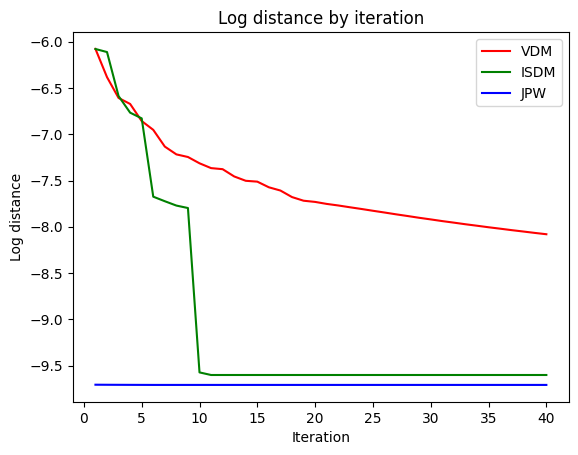

In [66]:
index = np.arange(1, 41)
plt.plot(index, np.log(result_vdm[0]), color = 'red', label = 'VDM')
plt.plot(index, np.log(result_isdm[0]), color = 'green', label = 'ISDM')
plt.plot(index, np.log(result_emp[0]), color = 'blue', label = 'JPW')
plt.xlabel('Iteration')
plt.ylabel('Log distance')
plt.title('Log distance by iteration')
plt.legend()

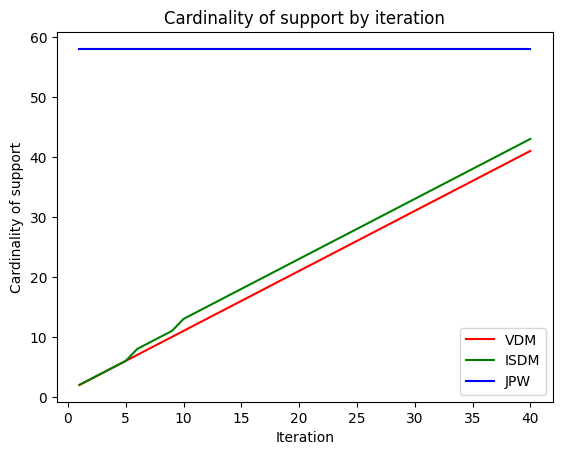

In [67]:
index = np.arange(1, 41)
plt.plot(index, result_vdm[1], color = 'red', label = 'VDM')
plt.plot(index, result_isdm[1], color = 'green', label = 'ISDM')
plt.plot(index, result_emp[1], color = 'blue', label = 'JPW')
plt.xlabel('Iteration')
plt.ylabel('Cardinality of support')
plt.title('Cardinality of support by iteration')
plt.legend()